In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from scipy import stats
import seaborn as sns

In [2]:
cd /home/tommy/Desktop/EAP project

/home/tommy/Desktop/EAP project


In [3]:
raw = pd.read_excel('ppi_fwds.xlsx')

In [4]:
raw.columns = ['Dates','FX','PPI','Pair','3m','6m','12m']
pairs = raw.Pair.unique()

#test code don't run this
pair = []
for elem in pairs:
    df= raw.loc[raw.Pair == elem,:]
    df.reset_index()
    df['PPP']= df.FX.shift(1)*(df.PPI/df.PPI.shift(1))#calculating PPP
    df1 = df[1:].reset_index().fillna(value=0).iloc[:,1:]
    pair.append(df1)

In [5]:
#group by currency, store them in an array of dataframes
pair = []
for elem in pairs:
    df= raw.loc[raw.Pair == elem,:]
    df = df.reset_index(drop=True)
    pair.append(df)

In [10]:
#############
elem = pair[0]
elem = elem.fillna(value=0)
X = sm.add_constant(elem.PPI)
model = sm.OLS(elem.FX,X).fit()
fitted = model.params[0] + model.params[1]*elem.PPI#fitted value
FX_greater = 1*(elem.FX > fitted)#fx > fitted?

In [11]:
#############
val = 0
months = []
for i in FX_greater: #computes number of consecutive months FX > fitted
    val = i + val * i
    months.append(val)
months = pd.Series(months)

#need another function to convert df to feed in proper data for plotting and hedging

In [6]:
#function to format df to input to hedge function
#pair -> pre_hedge -> hedge -> plot
def pre_h(df):
    df = df.fillna(value=0)
    X = sm.add_constant(df.PPI)
    model = sm.OLS(df.FX,X).fit()
    fitted = model.params[0]+model.params[1]*df.PPI ##OLS
    FX_greater = 1*(df.FX>fitted)
    
    val = 0
    months = []
    for i in FX_greater:
        val = i + val * i
        months.append(val)
    months = pd.Series(months) ##number of months FX > fitted
    
    m = np.array(months) #format dataframe
    f = np.array(fitted)
    M = np.array([m,f]).T
    df2 = pd.DataFrame(M,columns = ['months','fitted'])
    result = pd.concat([df,df2],axis=1,sort=False)
    return result

In [7]:
##hedging strategy function:
#input: dataframe, #months FX>fitted, 
#output: effective FX
#t1= waiting period before hedging
#t2 = hedging period (3,6,9,12 months?)
def hedge(df,t1,t2):
    FX_eff = []
    counter = 0 
    hedge = 1*(df.months > t1) #t1

    for (fx, h) in zip(df.FX, hedge):
        if h == 0 or (counter >= t2 and h ==1): #t2
            p = fx
            counter = 0
        else:
            counter += 1
        FX_eff.append(p)
    fxe = pd.DataFrame(FX_eff,columns=['FX_eff']) #effective fx    
    result = pd.concat([df,fxe],axis=1,sort=False)
    return result

In [50]:
 def dfplot(ax,df):
    ax.plot(df.Dates,df.fitted,c='red',linewidth = 1,label='PPP')#
    ax.plot(df.Dates,df.FX,c='blue',linewidth = 1,label='FX')#
    ax.plot(df.Dates,df.FX_eff,c='green',linewidth = 1,label='FXeff')#
    ax.set_title(df.Pair[0],fontsize ='xx-large', fontweight ='bold')#

    ax.legend(loc='upper right',prop={'size': 15})
    ax.set_xlabel('Date',fontsize ='xx-large', fontweight ='bold')
    ax.set_ylabel('FX rate', rotation = 90, fontsize ='xx-large',fontweight='bold')

In [58]:

[p1,p2,p3]=pair[1:4]
p1 = pre_h(p1)
p2 = pre_h(p2)
p3 = pre_h(p3)

######wait 3 period and hedge for 12 month
r1 = hedge(p1,3,12)
r2 = hedge(p2,3,12)
r3 = hedge(p3,3,12)
######wait 3 period and hedge for 6 months
rr1 = hedge(p1,3,6)
rr2 = hedge(p2,3,6)
rr3 = hedge(p3,3,6)

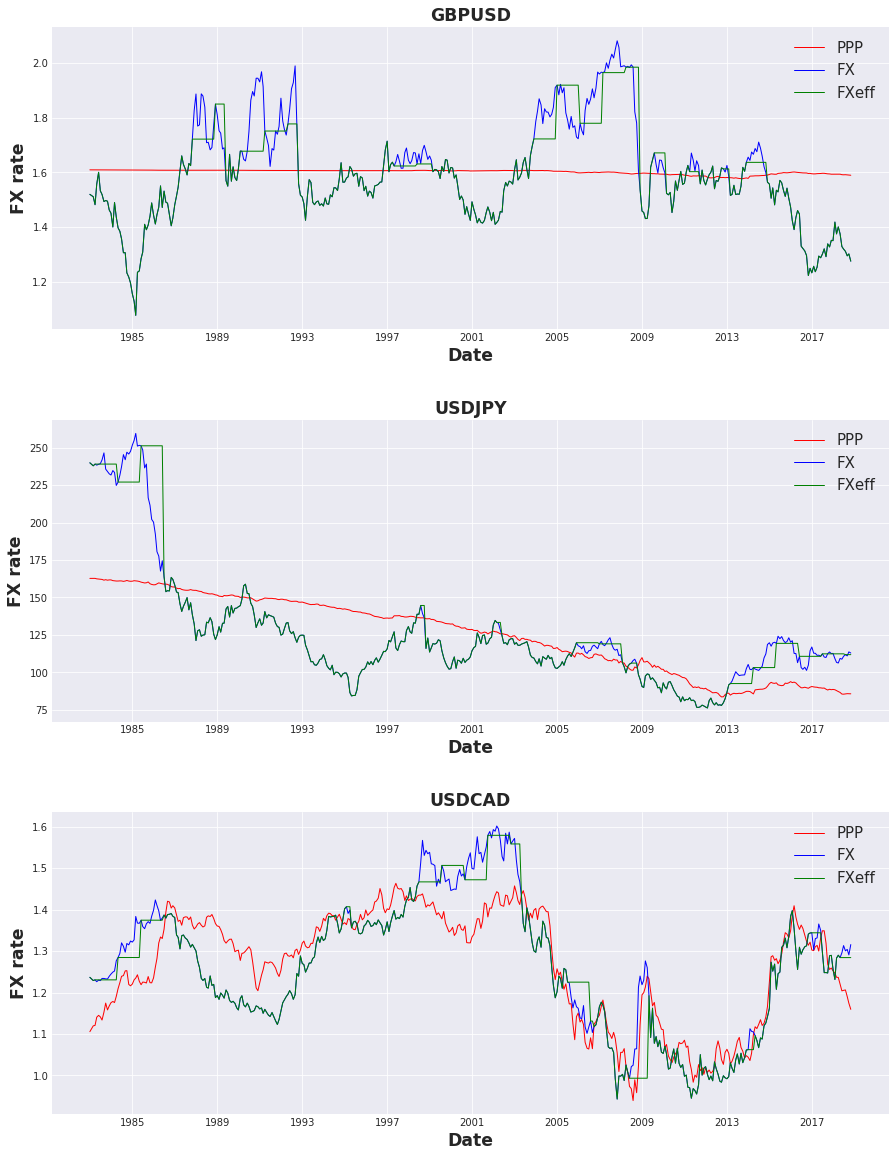

In [59]:
fig = plt.figure(figsize = (15,20))
ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)
dfplot(ax1,r1)
dfplot(ax2,r2)
dfplot(ax3,r3)
plt.subplots_adjust(hspace=0.3,wspace=0.5)

Text(0,0.5,'FX rate')

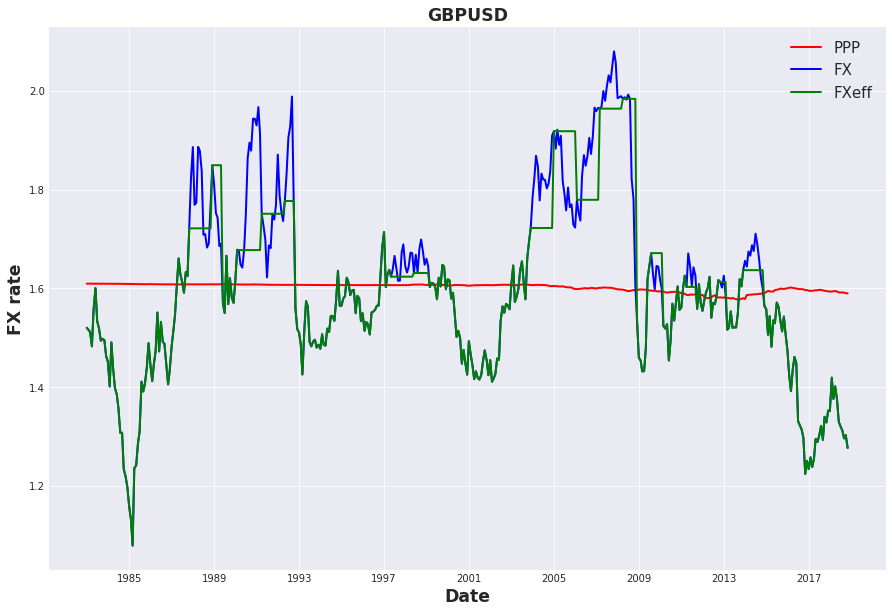

In [27]:
#plot
sns.set_style('darkgrid')
fig = plt.figure(figsize = (15,10))
ax=fig.add_subplot(1,1,1)

ax.plot(r1.Dates,r1.fitted,c='red',linewidth = 2,label='PPP')#
ax.plot(r1.Dates,r1.FX,c='blue',linewidth = 2,label='FX')#
ax.plot(r1.Dates,r1.FX_eff,c='green',linewidth = 2,label='FXeff')#
ax.set_title(r1.Pair[0],fontsize ='xx-large', fontweight ='bold')#

ax.legend(loc='upper right',prop={'size': 15})
ax.set_xlabel('Date',fontsize ='xx-large', fontweight ='bold')
ax.set_ylabel('FX rate', rotation = 90, fontsize ='xx-large',fontweight='bold')

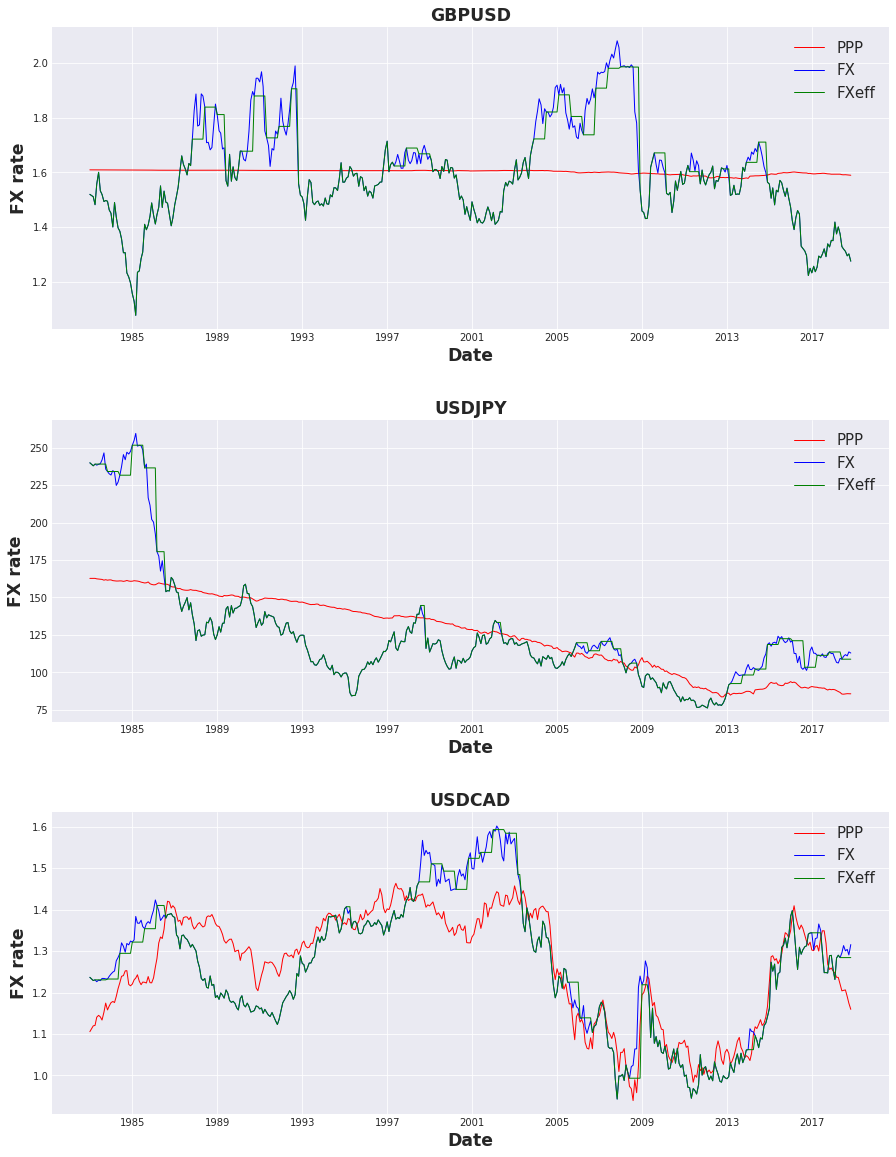

In [61]:
fig = plt.figure(figsize = (15,20))
ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)
dfplot(ax1,rr1)
dfplot(ax2,rr2)
dfplot(ax3,rr3)
plt.subplots_adjust(hspace=0.3,wspace=0.5)

Text(0,0.5,'FX rate')

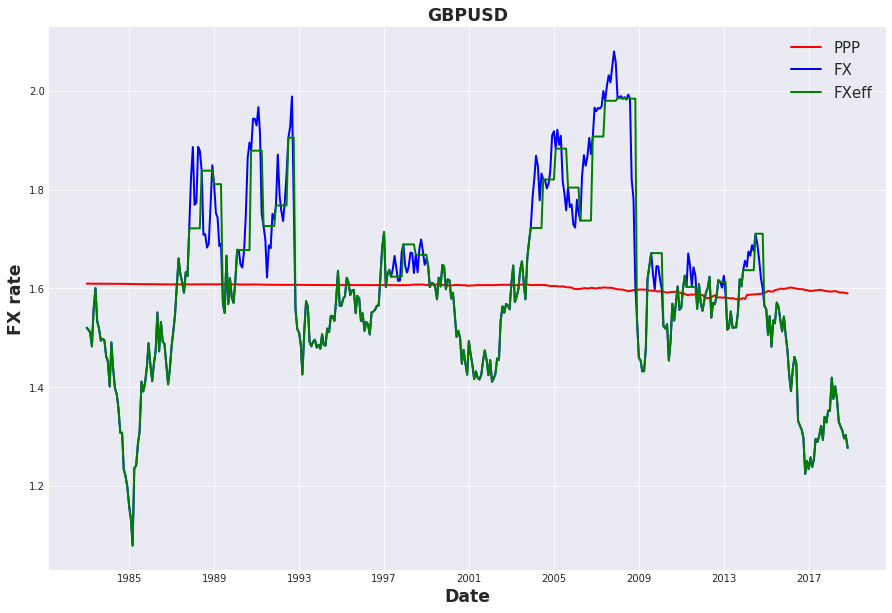

In [62]:
#plot
sns.set_style('darkgrid')
fig = plt.figure(figsize = (15,10))
ax=fig.add_subplot(1,1,1)

ax.plot(rr1.Dates,rr1.fitted,c='red',linewidth = 2,label='PPP')#
ax.plot(rr1.Dates,rr1.FX,c='blue',linewidth = 2,label='FX')#
ax.plot(rr1.Dates,rr1.FX_eff,c='green',linewidth = 2,label='FXeff')#
ax.set_title(rr1.Pair[0],fontsize ='xx-large', fontweight ='bold')#

ax.legend(loc='upper right',prop={'size': 15})
ax.set_xlabel('Date',fontsize ='xx-large', fontweight ='bold')
ax.set_ylabel('FX rate', rotation = 90, fontsize ='xx-large',fontweight='bold')